# Empirical Questions

In [802]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import statistics as stats
import scipy.linalg as la

This code is broken up into three seperate sections: 1:Functions 2:Data 3:Plots

In [803]:
import pandas as pd
df = pd.read_excel ('/Users/jackmontemurro/Desktop/APM466 CODE/Jan10-21 Bond Data.xlsx')
print(df)

    Coupon          ISIN  Issue Date Maturity Date  \
0   0.0050  CA135087G328  10/11/2016      3/1/2022   
1   0.0025  CA135087L286    5/4/2020      8/1/2022   
2   0.0175  CA135087H490   10/5/2017     2/28/2023   
3   0.0025  CA135087M359   5/14/2021      8/1/2023   
4   0.0075  CA135087M920  10/22/2021      2/1/2024   
5   0.0150  CA135087J967    4/4/2019     8/31/2024   
6   0.0125  CA135087K528  10/10/2019     2/28/2025   
7   0.0050  CA135087K940    4/2/2020     8/31/2025   
8   0.0025  CA135087L518    10/8/202     2/28/2026   
9   0.0100  CA135087L930   4/16/2021      9/1/2026   
10  0.0150  CA135087K601   11/4/2019      2/1/2022   
11  0.0150  CA135087K866   1/26/2020     4/30/2022   
12  0.0925  CA135087UM44  12/15/1991      6/1/2022   
13  0.0275  CA135087ZU15   11/2/2008      6/1/2022   
14  0.0025  CA135087L369    8/17/202     11/1/2022   
15  0.0025  CA135087L773  10/25/2020     1/31/2023   
16  0.0150  CA135087A610  07/29/2012      5/1/2023   
17  0.0025  CA135087L856    

Below we take the data from excel and put it in an array that we can use our functions on.We will store the price data in a 10x10 array. 10 rows for 10 bonds, and 10 collumns for 10 days of closing prices. We also store the maturity dates and coupon data in seperate 10x1 lists.

In [804]:
maturity_data =[]
coupon_data = []
for i in range(10):
    maturity_data.append(df.loc[i,'Maturity Date'])
    coupon_data.append(df.loc[i,'Coupon'])

bond_data_array = np.zeros((10,10)) 
for i in range(10):
    for j in range(10):
        p = j+6
        bond_data_array[i][j]=df.iat[i,p]


We will use this function months to calculate the time to maturity:

In [805]:
def months(maturity_date, day_of_january):
    """
    maturity_date  |MM/DD/YYYY (str)
    day_of_january |Number day of january (float). Ex 10 (representing January 10). It is easier to iterate over 
                   |the data this way
    """
    
    maturity_date_split = maturity_date.split('/')
    maturity_year = int(maturity_date_split[2])
    maturity_month = int(maturity_date_split[0])
    maturity_day = int(maturity_date_split[1])
    
    year_difference =  maturity_year - 2022
    month_difference = maturity_month - 1
    day_difference = maturity_day - day_of_january
    
    months = 12*year_difference + month_difference + day_difference/31
    return months

Below are two functions that will do all the work for our calculation of ytm. One returns the discounted cashflow with a specified rate, and the second calculates what that rate must be in order to have the present price of a bond be equal to its discounted cashflow.

In [806]:
def present_value(P,C,T,r):
    """
    Given a bond price P, its Coupon C and time to maturity T (in months), we calculate a discounted cash flow 
    for a given rate r. 
    Parameters:
    P | current bond price, ex. 100.07 (float)
    C | coupon, as percentage, ex. 0.01 (float)
    T | time to maturity in months, ex. 134 (float)
    r | YTM ex 1.01 (float)
    """ 
    time = T
    scale_r= r/100  #We scale by 100 as it makes root solving done in ytm() more robust
    actual_coupon = 100*C/2 #dollar value recieved as bi-annual coupon payments
    present_value = (100+actual_coupon)*np.exp(-scale_r*time/12) 
    time += - 6
    while time > 0:
        present_value += actual_coupon*np.exp(-scale_r*time/12)
        time += - 6
    return present_value

def ytm(P,C,T):
    """
    Given a bond price P, its coupon C and its time to maturity T this returns the internal rate of return (YTM) 
    that makes the discounted cash flow equal to the current price.
    Parameters:
    P | current bond price, ex. 100.07 (float)
    C | coupon, as percentage, ex. 0.01 (float)
    T | time to maturity in months, ex. 13 (float)
    """
    actual_coupon = 100*C/2
    f = lambda r: P - present_value(P,C,T,r) + (6-T%6)/6*actual_coupon
    sol = fsolve(f, 1)
    return sol

Below we plot the results that our ytm calculator provides:

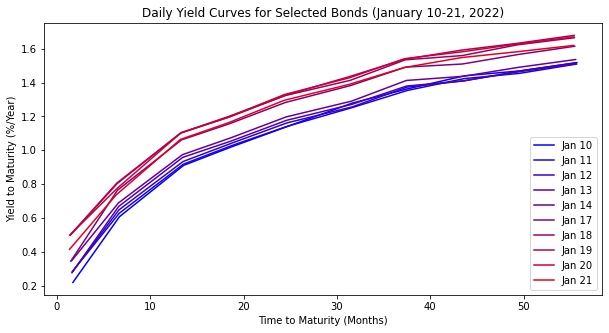

In [807]:
ytm_array = np.zeros((10,10)) #a place to store ytm for day each day, different row represent different days
for i in range(10):
    ytm_day_i = np.zeros((10,1)) #a place to store ytm for day i
    time_till_maturity = np.zeros((10,1)) #a place to store time till maturity
    if i > 4:
        p = 12 #need to acount for the 2 days in the weekend
    else:
        p = 10
    for j in range(10):
        time_till_maturity[j] = months(maturity_data[j],i+p) #record time till maturity
        ytm_array[i,j] = ytm(bond_data_array[j,i],coupon_data[j],months(maturity_data[j],i+10)) #record ytm's
    date = "Jan " + str(i+p)    
    plt.plot(time_till_maturity,ytm_array[i], label = date, color = (i/10, 0, 1-i/10))
    plt.legend(loc = 'lower right')
    plt.xlabel("Time to Maturity (Months)")
    plt.ylabel("Yield to Maturity (%/Year)")
    plt.title ("Daily Yield Curves for Selected Bonds (January 10-21, 2022)")
    plt.rcParams["figure.figsize"] = (10,5)
plt.savefig('yield_curve.png', dpi = 400)

In [809]:
def present_value_spot(price, coupon, maturity, rate_vec, r):
    """
    Given a set of known rates stored in rate_vec, calculate the present value of a cash flow of a given bond. 
    Parameters:

    price    | bond prices at current value. (float) ex. 100.99
             |
    coupon   | coupon associated to above bond. (float) ex. 0.01
             |
    maturity | maturity (in months) associated to bond (float) ex 145
             |
    rate_vec | array of KNOWN spot rates and their times.First row is rates, second row is time (in month). (array)
             | ex. [[6,1.5],[12,1.6],[18,1.7]]  
    r        |
                
    """
    period = maturity/6  #number of 6 month periods until maturity, approximate    
    scale_r= r/100  #We scale by 100 as it makes root solving done in rate() more robust
    actual_coupon = 100*coupon/2
    present_value = (100+actual_coupon)*np.exp(-scale_r*maturity/12)
    period += -1
    while period > 0:
        present_value += actual_coupon*np.exp(-(rate_vec[math.floor(period)][0]/100)*period/2)
        period += - 1
    return present_value
def rate(price, coupon, maturity, rate_vec):
    actual_coupon = 100*coupon/2
    f = lambda r: present_value_spot(price, coupon, maturity, rate_vec, r) -  price - (6-maturity%6)/6*actual_coupon
    sol = fsolve(f, 1)
    return sol

In [810]:
def spot_rate_calc(price_vec, coupon_vec, maturity_vec):
    """
    Given bond prices, their coupons and their time to maturity, calculate a spot rate. returns an array rate_vec such 
    rate_vec[i][1]= t_i (time stamp) and rate_vec[i][2]=r(t_i) where r is the spot curve. 

    Parameters:
    
    price_vec    | array of bond prices at current value. bonds must be arranged by increasing maturity date and should 
                 | have maturities dates roughly 6 months apart from each other. The first bond must mature in at most 6 
                 | months. (array) ex. [100, 99, 99.5]
                 |
    coupon_vec   | coupons associated to bonds in price_vec. (array) ex [0.01,0.025,0.03]
                 |
    maturity_vec | time till maturity (in months) associated to bonds in price_vec.(array) ex [3,9,15]
             
    """
    num_bonds = price_vec.shape[0] #return the number of bonds
    rate_vec =np.zeros((num_bonds,2))
    first_coupon = maturity_vec[0]
    for i in range(num_bonds):
        rate_vec[i][0]= rate(price_vec[i],coupon_vec[i],maturity_vec[i], rate_vec)
        rate_vec[i][1]= maturity_vec[i]
    
    return rate_vec

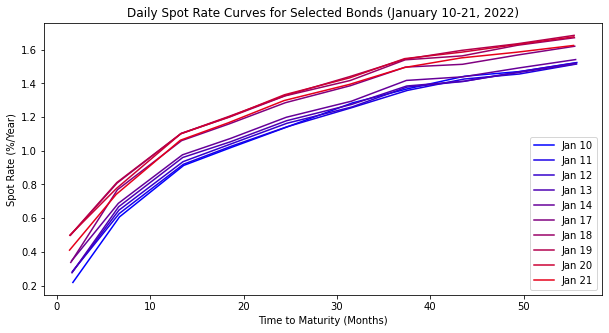

In [811]:
spot_curve_array =np.zeros((10,10)) #a place to store the spot rate values, rows are different days
for i in range(10):
    time_till_maturity = np.zeros((10,1)) #a place to store time till maturity
    if i > 4:
        p = 12 #need to acount for the 2 days in the weekend
    else:
        p = 10
    for j in range(10):
        time_till_maturity[j] = months(maturity_data[j],i+p) #record time till maturity
    
    spot_curve_array[i] = spot_rate_calc(bond_data_array[:,i],coupon_data,time_till_maturity)[:,0] #record spot rates
    date = "Jan " + str(i+p)    
    plt.plot(time_till_maturity,spot_curve_array[i], label = date,color = (i/10, 0, 1-i/10))
    plt.legend(loc = 'lower right')
    plt.xlabel("Time to Maturity (Months)")
    plt.ylabel("Spot Rate (%/Year)")
    plt.title ("Daily Spot Rate Curves for Selected Bonds (January 10-21, 2022)")
    plt.rcParams["figure.figsize"] = (10,5)
plt.savefig('spot_curve.png', dpi = 400)

In [813]:
def forward_rate(price_vec, coupon_vec, maturity_vec, n):
    """
    Given bond prices (all spaced roughly 6 monts apart, one bond maturing in roughly one year), their coupons and time to 
    maturity (in months) return an array of the 1yr-1yr,1yr-2yr,1yr-3yr,1yr-4yr, year forward rates. 
    Since discreet data is  being used the 1-1 year rate will be an approximiation 
    to the derivative done using the secant method. n is the index of price_vec which holds the 1 year bond.
    
    Parameters:
    
    price_vec    | array of bond prices at current value. bonds must be arranged by increasing maturity date and should 
                 | have maturities dates roughly 6 months apart from each other. One bond musy mature 
                 | in 1 year(array) ex. [100, 99, 99.5]
                 |
    coupon_vec   | coupons associated to bonds in price_vec. (array) ex [0.01,0.025,0.03]
                 |
    maturity_vec | time till maturity (in months) associated to bonds in price_vec.(array) ex [0.5,1,1.5]
    
    
    """

    forward_rates = np.zeros((4,1))
    
    spot_rate_curve = spot_rate_calc(price_vec,coupon_vec,maturity_vec)
    
    """
    1yr-1yr forward rate calculation:
    
    Seperate from the rest since a derivative is required
    We will approximate te derivative by f' "=" (right_derivative_of_f + right_derivative_of_f)/2
    Since we have discrete data, the one-sided derivatives will be calculated by simple calculating the 
    rise over run of the spot curve, Note that the 1:1 rate is the derivative of t*s(t) at t = 1 where s is the 
    spot curve, not s'(t). 
    """
    
    
    left_derivative = (spot_rate_curve[n,0]-spot_rate_curve[n-1,0])/((spot_rate_curve[n,1]-spot_rate_curve[n-1,1])/12)
    right_derivative =(spot_rate_curve[n+1,0]-spot_rate_curve[n,0])/((spot_rate_curve[n+1,1]-spot_rate_curve[n,1])/12)
    derivative = (left_derivative+right_derivative)/2
    
    a = spot_rate_curve[n+1,0]*spot_rate_curve[n+1,1]/12-spot_rate_curve[n,0]*spot_rate_curve[n,1]/12
    b = (spot_rate_curve[n+1,1]-spot_rate_curve[n,1])/12
    
    
    forward_rates[0]= right_derivative*spot_rate_curve[n,1]/12+spot_rate_curve[n,0]
    
    for i in range(1,4):
        #To be consistent we will stick with continous compounding
        a = (spot_rate_curve[n+2*i,0]*spot_rate_curve[n+2*i,1]/12)-spot_rate_curve[n,0]*spot_rate_curve[n,1]/12
        b = (spot_rate_curve[n+2*i,1]-spot_rate_curve[n,1])/12
        forward_rates[i]= a/b 
    
    return forward_rates
    
    
    
    
    

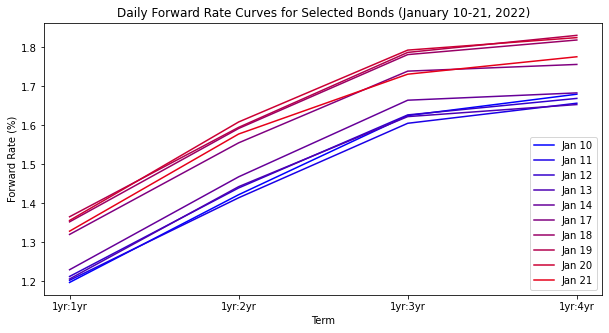

In [815]:
forward_array = np.zeros((10,4))# a place to store the forward curves, different rows are different days
for i in range(10):
    time_till_maturity = np.zeros((10,1)) #a place to store time till maturity
    if i > 4:
        p = 12 #need to acount for the 2 days in the weekend
    else:
        p = 10
    for j in range(10):
        time_till_maturity[j] = months(maturity_data[j],i+p) #record time till maturity
    
    forward_array[i] = forward_rate(bond_data_array[:,i],coupon_data,time_till_maturity,2).squeeze() #record forward rates
    date = "Jan " + str(i+p)    
    plt.plot(['1yr:1yr','1yr:2yr','1yr:3yr','1yr:4yr'],forward_array[i], label = date,color = (i/10, 0, 1-i/10))
    plt.legend(loc = 'lower right')
    plt.xlabel("Term")
    plt.ylabel("Forward Rate (%)")
    plt.title ("Daily Forward Rate Curves for Selected Bonds (January 10-21, 2022)")
    plt.rcParams["figure.figsize"] = (10,5)
plt.savefig('forward_curve.png',dpi = 400)

In [685]:
def sample_covariance(X):
    """
    Given an mxn array, X where the n collumns are samples from a random vector Y with m entries, calculate 
    an estimate of the covariance of Y.
    """
    
    (m,n) = np.shape(X)
    
    #calculating the emprical mean of Y:
    mu = np.zeros((m,1))
    for i in range(m):
        mu[i]=stats.mean(X[i,:])
    
    #calculating covariance
    cov = np.zeros((m,m))
    cov = 1/(10-1)*np.zeros((10,10))
    for i in range(n):
        x = X[:,i]-mu.transpose()
        cov += np.matmul(x.transpose(),x)

    return 1/(n-1)*cov

In [686]:
def log_returns(X):
    """
    Given an mxn array, X, where the n collumns are time series from a random vector Y with m entries, return an 
    mx(n-1) array of the log returns of this time seires, ie return R s.t R_i,j = log((X_i,j+1)/X_ij)
    """
    (m,n) = np.shape(X)
    R = np.zeros((m,n-1))
    for i in range(m):
        for j in range(n-1):
            R[i,j]=np.log(X[i,j+1]/X[i,j])
    return R 

In [822]:
def bmatrix(a): #A function that turns an array into a Latex bmatrix
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [823]:
"Calculating the Covariance for Forward Rates"
cov_forward = np.cov(log_returns(forward_array.transpose()))
eig_forward = la.eig(a)
eig_forward

(array([2.07842856e-03+0.j, 8.72656184e-05+0.j, 3.48778230e-05+0.j,
        1.26700081e-05+0.j]),
 array([[ 0.55183768,  0.75553246,  0.21634747, -0.27899758],
        [ 0.46673936,  0.06460751, -0.65650123,  0.58905549],
        [ 0.49331511, -0.51823509, -0.27609769, -0.64174968],
        [ 0.4840142 , -0.39551101,  0.66780983,  0.4041427 ]]))

In [832]:
print(bmatrix(cov_forward))

\begin{bmatrix}
  0.00068537 & 0.00053255 & 0.00053183 & 0.00053268\\
  0.00053255 & 0.00047257 & 0.00047717 & 0.00045503\\
  0.00053183 & 0.00047717 & 0.00053712 & 0.00050444\\
  0.00053268 & 0.00045503 & 0.00050444 & 0.00051819\\
\end{bmatrix}


In [835]:
eig_vec_forward = np.array([[ 0.55183768,  0.75553246,  0.21634747, -0.27899758],
        [ 0.46673936,  0.06460751, -0.65650123,  0.58905549],
        [ 0.49331511, -0.51823509, -0.27609769, -0.64174968],
        [ 0.4840142 , -0.39551101,  0.66780983,  0.4041427 ]])
eig_val_forward = np.array([2.07842856e-03+0.j, 8.72656184e-05+0.j, 3.48778230e-05+0.j,
        1.26700081e-05+0.j])

print(bmatrix(eig_vec_forward))  
print(bmatrix(eig_val_forward))

\begin{bmatrix}
  0.55183768 & 0.75553246 & 0.21634747 & -0.27899758\\
  0.46673936 & 0.06460751 & -0.65650123 & 0.58905549\\
  0.49331511 & -0.51823509 & -0.27609769 & -0.64174968\\
  0.4840142 & -0.39551101 & 0.66780983 & 0.4041427\\
\end{bmatrix}
\begin{bmatrix}
  2.07842856e-03+0.j & 8.72656184e-05+0.j & 3.48778230e-05+0.j\\
  1.26700081e-05+0.j\\
\end{bmatrix}


In [838]:
"Calculating the Coaraviance for Yield Curves"
#First we have to just select the bonds seperated by a year
ytm_array_five_year = np.concatenate(([ytm_array[:,1]],[ytm_array[:,3]],[ytm_array[:,5]],[ytm_array[:,7]],[ytm_array[:,9]]))
cov_ytm = np.cov(log_returns(ytm_array_five_year))
eig_ytm = la.eig(v)
eig_ytm

(array([4.38111997e-03+0.j, 3.70477796e-04+0.j, 7.57585748e-06+0.j,
        3.70405340e-05+0.j, 5.78680748e-05+0.j]),
 array([[-0.67262817,  0.67495105,  0.08723929,  0.27019204,  0.10676135],
        [-0.42240603, -0.04846045, -0.57910412, -0.61537443, -0.32431074],
        [-0.39462031, -0.48206058,  0.27429937,  0.38058676, -0.62594407],
        [-0.31614178, -0.49157705, -0.42740066,  0.34237119,  0.59876291],
        [-0.33685854, -0.26088745,  0.63175649, -0.53501986,  0.36483085]]))

In [839]:
print(bmatrix(cov_ytm))

\begin{bmatrix}
  0.00215434 & 0.00122411 & 0.00104247 & 0.00081555 & 0.00092476\\
  0.00122411 & 0.00080523 & 0.00074081 & 0.00057672 & 0.00063065\\
  0.00104247 & 0.00074081 & 0.00079695 & 0.00061661 & 0.00060954\\
  0.00081555 & 0.00057672 & 0.00061661 & 0.00055387 & 0.00051789\\
  0.00092476 & 0.00063065 & 0.00060954 & 0.00051789 & 0.00054369\\
\end{bmatrix}


In [841]:
eig_vec_ytm = np.array([[-0.67262817,  0.67495105,  0.08723929,  0.27019204,  0.10676135],
        [-0.42240603, -0.04846045, -0.57910412, -0.61537443, -0.32431074],
        [-0.39462031, -0.48206058,  0.27429937,  0.38058676, -0.62594407],
        [-0.31614178, -0.49157705, -0.42740066,  0.34237119,  0.59876291],
        [-0.33685854, -0.26088745,  0.63175649, -0.53501986,  0.36483085]])
eig_val_ytm = np.array([4.38111997e-03+0.j, 3.70477796e-04+0.j, 7.57585748e-06+0.j,
        3.70405340e-05+0.j, 5.78680748e-05+0.j])
print(bmatrix(eig_vec_ytm))
print(bmatrix(eig_val_ytm))

\begin{bmatrix}
  -0.67262817 & 0.67495105 & 0.08723929 & 0.27019204 & 0.10676135\\
  -0.42240603 & -0.04846045 & -0.57910412 & -0.61537443 & -0.32431074\\
  -0.39462031 & -0.48206058 & 0.27429937 & 0.38058676 & -0.62594407\\
  -0.31614178 & -0.49157705 & -0.42740066 & 0.34237119 & 0.59876291\\
  -0.33685854 & -0.26088745 & 0.63175649 & -0.53501986 & 0.36483085\\
\end{bmatrix}
\begin{bmatrix}
  4.38111997e-03+0.j & 3.70477796e-04+0.j & 7.57585748e-06+0.j\\
  3.70405340e-05+0.j & 5.78680748e-05+0.j\\
\end{bmatrix}
